In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from statistics import mean
from sklearn.neural_network import MLPClassifier
import time
import ast
sns.set_theme()

In [2]:
stateful_df = pd.read_csv("Data/Prepared Data/stateful.csv")
stateless_df = pd.read_csv("Data/Prepared Data/stateless.csv")
stateless_df = stateless_df.fillna("")

# Stateless Model - Reimplementation

Train Accuracy: 0.7519314324956089
Test Accuracy: 0.7521047522830372
Total time elapsed for prediction: 5.70
Train Accuracy: 0.7554513354100325
Test Accuracy: 0.7353772401315355
Total time elapsed for prediction: 6.58
Train Accuracy: 0.7495794601572546
Test Accuracy: 0.7621729771133503
Total time elapsed for prediction: 5.40
Train Accuracy: 0.7484090470129703
Test Accuracy: 0.762311644061753
Total time elapsed for prediction: 7.11
Train Accuracy: 0.7526350803689195
Test Accuracy: 0.7465894533880958
Total time elapsed for prediction: 6.93


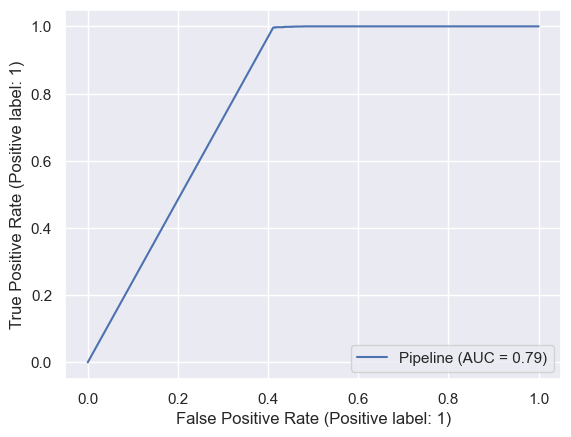

In [3]:
stateless_df["Predictions"] = 0
skf = StratifiedKFold(n_splits=5)
X = stateless_df[[col for col in stateless_df.columns if col not in ["timestamp", "attack", "origin", "data_type", "original_index"]]]
y = stateless_df["attack"]
trained_pipes_mlpc = []
categorical_transformer_pipes=[]
accuracies = []
total_prediction_time_stateless=0
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    category_pipeline = ColumnTransformer(
    [
     ('ordinal_encoder', OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), ["longest_word", "sld"]),
     ('scaler', StandardScaler(), [col for col in X_train if col not in ["longest_word", "sld"]])
     ]
    )
    X_train = category_pipeline.fit_transform(X_train)
    pipe = Pipeline([('mlpc',MLPClassifier(random_state=12))])
    t0 = time.time()
    pipe.fit(X_train, y_train)
    prediction_time_start = time.time()
    X_test = category_pipeline.transform(X_test)
    #print(X_test)
    print("Train Accuracy:", pipe.score(X_train, y_train))
    print("Test Accuracy:", pipe.score(X_test, y_test))
    stateless_df.loc[test_index, 'Predictions'] = pipe.predict(X_test)
    prediction_time_end = time.time()
    print(f"Total time elapsed for prediction: {(prediction_time_end - prediction_time_start):.2f}")
    total_prediction_time_stateless += (prediction_time_end - prediction_time_start)
    trained_pipes_mlpc.append(pipe)
    categorical_transformer_pipes.append(category_pipeline)

    
mlpc_disp = RocCurveDisplay.from_estimator(pipe, X_test, y_test)
plt.show()    


In [4]:
print(f"Total prediction time for {stateless_df.shape[0]} rows is {total_prediction_time_stateless:.3f}")
single_datapoint_evaluation_time_stateless = total_prediction_time_stateless/stateless_df.shape[0]
print(f"Time to evaluate a single data point: {single_datapoint_evaluation_time_stateless:.8f}")

Total prediction time for 757211 rows is 31.715
Time to evaluate a single data point: 0.00004188


## Overall Results

In [5]:
display(pd.DataFrame(classification_report(stateless_df["attack"], stateless_df["Predictions"], output_dict=True)).T)

,precision,recall,f1-score,support
0,0.992987,0.598037,0.746491,462858.000000
1,0.611136,0.993358,0.756721,294353.000000
accuracy,0.751711,0.751711,0.751711,0.751711
macro avg,0.802061,0.795697,0.751606,757211.000000
weighted avg,0.844549,0.751711,0.750468,757211.000000


## Light-attack

In [6]:
temp = stateless_df[(stateless_df["origin"]=="light-attack")
                  | (stateless_df["origin"]=="light-benign")]
display(pd.DataFrame(classification_report(temp["attack"], temp["Predictions"], output_dict=True)).T)

,precision,recall,f1-score,support
0,0.997656,0.609043,0.756352,60091.000000
1,0.644530,0.997985,0.783227,42683.000000
accuracy,0.770574,0.770574,0.770574,0.770574
macro avg,0.821093,0.803514,0.769790,102774.000000
weighted avg,0.850999,0.770574,0.767514,102774.000000


## Heavy-attack

In [7]:
temp = stateless_df[(stateless_df["origin"]=="heavy-attack")
                  | (stateless_df["origin"]=="heavy-benign")]
display(pd.DataFrame(classification_report(temp["attack"], temp["Predictions"], output_dict=True)).T)

,precision,recall,f1-score,support
0,0.983265,0.604373,0.748608,181694.000000
1,0.776542,0.992574,0.871367,251670.000000
accuracy,0.829815,0.829815,0.829815,0.829815
macro avg,0.879903,0.798473,0.809988,433364.000000
weighted avg,0.863213,0.829815,0.819899,433364.000000


In [8]:
stateless_df.Predictions.value_counts(normalize=True)

1    0.631858
0    0.368142
Name: Predictions, dtype: float64

# Stateful Model Reimplementation

In [9]:
stateful_df.columns

Index(['rr', 'A_frequency', 'NS_frequency', 'CNAME_frequency', 'SOA_frequency',
       'NULL_frequency', 'PTR_frequency', 'HINFO_frequency', 'MX_frequency',
       'TXT_frequency', 'AAAA_frequency', 'SRV_frequency', 'OPT_frequency',
       'rr_type', 'rr_count', 'rr_name_entropy', 'rr_name_length',
       'distinct_ns', 'distinct_ip', 'unique_country', 'unique_asn',
       'distinct_domains', 'reverse_dns', 'a_records', 'unique_ttl',
       'ttl_mean', 'ttl_variance', 'original_index', 'data_type', 'attack',
       'origin'],
      dtype='object')

Train Accuracy: 0.7914957745941512
Test Accuracy: 0.798916464775567
Total time elapsed for prediction: 1.77
Train Accuracy: 0.6820310562560806
Test Accuracy: 0.6784876290036436
Total time elapsed for prediction: 1.45
Train Accuracy: 0.5672678888231816
Test Accuracy: 0.5956391522481448
Total time elapsed for prediction: 1.43
Train Accuracy: 0.7927691192461037
Test Accuracy: 0.793842162492131
Total time elapsed for prediction: 1.57
Train Accuracy: 0.7926403540565804
Test Accuracy: 0.7872226779344156
Total time elapsed for prediction: 1.41


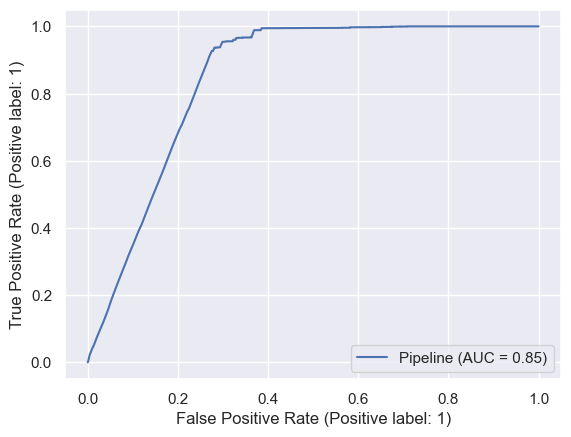

In [12]:
stateful_df["Predictions"] = 0
skf = StratifiedKFold(n_splits=5)
categorical_features = ["rr_type", "distinct_ip", "unique_country",
"unique_asn", "distinct_domains", "reverse_dns"]
X = stateful_df[[col for col in stateful_df.columns if col not in ["unique_ttl", "attack", "origin", "data_type", "original_index"]]]
y = stateful_df["attack"]
trained_pipes_mlpc = []
categorical_transformer_pipes=[]
accuracies = []
total_prediction_time_stateful=0
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    category_pipeline = ColumnTransformer(
    [
     ('ordinal_encoder', OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), categorical_features),
     ('scaler', StandardScaler(), [col for col in X_train if col not in categorical_features])
     ]
    )
    X_train = category_pipeline.fit_transform(X_train)
    pipe = Pipeline([('mlpc',MLPClassifier(random_state=12))])
    pipe.fit(X_train,y_train)
    prediction_time_start = time.time()
    X_test = category_pipeline.transform(X_test)
    #print(X_test)
    print("Train Accuracy:", pipe.score(X_train, y_train))
    print("Test Accuracy:", pipe.score(X_test, y_test))
    stateless_df.loc[test_index, 'Predictions'] = pipe.predict(X_test)
    prediction_time_end = time.time()
    print(f"Total time elapsed for prediction: {(prediction_time_end - prediction_time_start):.2f}")
    total_prediction_time_stateful += (prediction_time_end - prediction_time_start)
    trained_pipes_mlpc.append(pipe)
    categorical_transformer_pipes.append(category_pipeline)

mlpc_disp = RocCurveDisplay.from_estimator(pipe, X_test, y_test)
plt.show() 

In [13]:
print(f"Total prediction time for {stateful_df.shape[0]} rows is {total_prediction_time_stateful:.3f}")
single_datapoint_evaluation_time_stateful = total_prediction_time_stateful/stateful_df.shape[0]
print(f"Time to evaluate a single data point: {single_datapoint_evaluation_time_stateful:.8f}")

Total prediction time for 262105 rows is 7.630
Time to evaluate a single data point: 0.00002911


## Overall Results

In [14]:
display(pd.DataFrame(classification_report(stateful_df["attack"], stateful_df["Predictions"], output_dict=True)).T)

c:\python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.682101,1.000000,0.811011,178782.000000
1,0.000000,0.000000,0.000000,83323.000000
accuracy,0.682101,0.682101,0.682101,0.682101
macro avg,0.341050,0.500000,0.405505,262105.000000
weighted avg,0.465261,0.682101,0.553191,262105.000000


## Light Attack Results

In [15]:
temp = stateful_df[(stateful_df["origin"]=="light-attack")
                  | (stateful_df["origin"]=="light-benign")]
display(pd.DataFrame(classification_report(temp["attack"], temp["Predictions"], output_dict=True)).T)

c:\python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.668409,1.000000,0.801253,22768.000000
1,0.000000,0.000000,0.000000,11295.000000
accuracy,0.668409,0.668409,0.668409,0.668409
macro avg,0.334204,0.500000,0.400626,34063.000000
weighted avg,0.446770,0.668409,0.535564,34063.000000


## Heavy Attack Results

In [16]:
temp = stateful_df[(stateful_df["origin"]=="heavy-attack")
                  | (stateful_df["origin"]=="heavy-benign")]
display(pd.DataFrame(classification_report(temp["attack"], temp["Predictions"], output_dict=True)).T)

c:\python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.489322,1.000000,0.657107,69016.000000
1,0.000000,0.000000,0.000000,72028.000000
accuracy,0.489322,0.489322,0.489322,0.489322
macro avg,0.244661,0.500000,0.328554,141044.000000
weighted avg,0.239436,0.489322,0.321537,141044.000000


In [17]:
stateful_df.origin.value_counts()

only-benign     86998
heavy-attack    72028
heavy-benign    69016
light-benign    22768
light-attack    11295
Name: origin, dtype: int64

In [18]:
WINDOW_SIZE=100
SUSPICIOUS_THRESHOLD = 0.4
ATTACK_THRESHOLD = 0.7

In [19]:
def two_step(stateless_df, stateful_df, is_light=True):
    estimated_time = 0
       
    if is_light:
        light_or_heavy_string = "light"
    else:
        light_or_heavy_string = "heavy"
        
    stateless_df_subset = stateless_df[stateless_df.origin.isin([light_or_heavy_string+"-benign", light_or_heavy_string+"-attack"])].reset_index()
    stateless_df_subset["Final_two_step_prediction"] = stateless_df_subset["Predictions"]
    stateful_df_subset = stateful_df[stateful_df.origin.isin([light_or_heavy_string+"-benign", light_or_heavy_string+"-attack"])].reset_index()
    stateful_df_subset["Final_two_step_prediction"] = stateful_df_subset["Predictions"] 
    stateful_df_subset['unique_ttl'] = stateful_df_subset['unique_ttl'].apply(ast.literal_eval)
    stateful_df_subset = stateful_df_subset.explode("unique_ttl")

    time_windows = []
    attack_ratios = []

    for i in range(0, stateless_df_subset.shape[0], WINDOW_SIZE):
        current_data = stateless_df_subset.iloc[i:i+WINDOW_SIZE]
        attack_ratio = (current_data[current_data["Predictions"]==1].shape[0]/current_data.shape[0])
        time_windows.append(i)
        attack_ratios.append(attack_ratio)
        estimated_time += (single_datapoint_evaluation_time_stateless * WINDOW_SIZE)
        if attack_ratio >= ATTACK_THRESHOLD:
            stateless_df_subset.loc[[i for i in range(i, min(i+WINDOW_SIZE, stateless_df_subset.shape[0]))], 'Final_two_step_prediction'] = 1
        elif attack_ratio < SUSPICIOUS_THRESHOLD:
            stateless_df_subset.loc[[i for i in range(i, min(i+WINDOW_SIZE, stateless_df_subset.shape[0]))], 'Final_two_step_prediction'] = 0
        else:
            estimated_time += (single_datapoint_evaluation_time_stateful * WINDOW_SIZE)
            stateful_data_window = stateful_df_subset.iloc[i:i+WINDOW_SIZE]
            stateful_attack_ratio = (stateful_data_window[stateful_data_window["Predictions"]==1].shape[0]/stateful_data_window.shape[0])
            if stateful_attack_ratio >= 0.5:
                stateless_df_subset.loc[[i for i in range(i, min(i+WINDOW_SIZE, stateless_df_subset.shape[0]))], 'Final_two_step_prediction'] = 1
            elif stateful_attack_ratio < 0.5:
                stateless_df_subset.loc[[i for i in range(i, min(i+WINDOW_SIZE, stateless_df_subset.shape[0]))], 'Final_two_step_prediction'] = 0

    plt.plot(time_windows, attack_ratios)
    plt.title("Stateless attack ratio over the 100-datapoint windows")
    plt.show()
    display(pd.DataFrame(classification_report(stateless_df_subset["attack"], stateless_df_subset["Final_two_step_prediction"], output_dict=True)).T)
    print("Total Estimated Time: ", estimated_time)

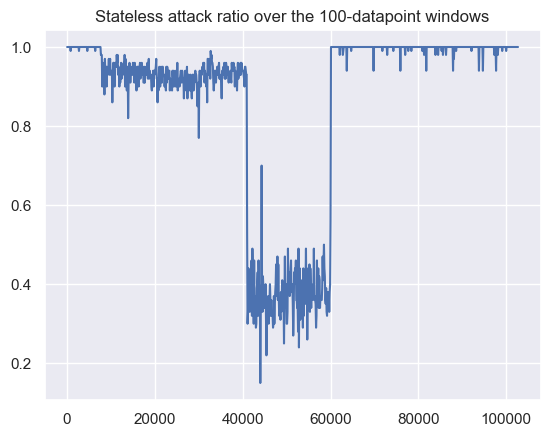

,precision,recall,f1-score,support
0,0.999526,0.316037,0.480232,60091.000000
1,0.509394,0.999789,0.674917,42683.000000
accuracy,0.600006,0.600006,0.600006,0.600006
macro avg,0.754460,0.657913,0.577574,102774.000000
weighted avg,0.795970,0.600006,0.561086,102774.000000


Total Estimated Time:  4.503579507310496


In [20]:
two_step(stateless_df, stateful_df, is_light=True)

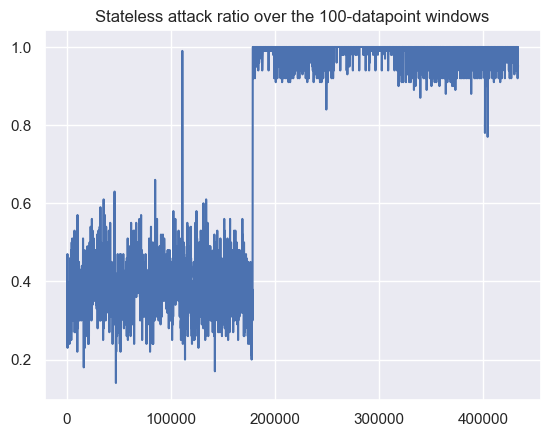

,precision,recall,f1-score,support
0,1.000000,0.980770,0.990292,181694.000000
1,0.986307,1.000000,0.993106,251670.000000
accuracy,0.991937,0.991937,0.991937,0.991937
macro avg,0.993153,0.990385,0.991699,433364.000000
weighted avg,0.992048,0.991937,0.991926,433364.000000


Total Estimated Time:  20.312275986768633


In [21]:
two_step(stateless_df, stateful_df, is_light=False)